# Strong App Fitness Analytics — Starter Notebook

This notebook loads your `data/strong.csv`, cleans it, and produces:
- Weekly training **volume** and **frequency**
- Top exercises by lifetime volume
- Personal records (heaviest set per exercise)
- A cleaned CSV saved to `data/cleaned_strong.csv`


## 0) Setup

In [1]:

# If needed (first run), install packages in your environment:
# %pip install pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
DATA_PATH = Path("data/strong.csv")
assert DATA_PATH.exists(), f"Expected a CSV at {DATA_PATH}. If missing, put your Strong export there."


## 1) Load Strong CSV (robust reader)

In [2]:

# Strong exports can have irregular lines; use python engine + on_bad_lines
df = pd.read_csv(DATA_PATH, engine="python", on_bad_lines="skip")
print("Loaded shape:", df.shape)
df.head(10)


Loaded shape: (392, 12)


,Date,Workout Name,Duration,Exercise Name,Set Order,Weight,Reps,Distance,Seconds,Notes,Workout Notes,RPE
0,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Triceps Pushdown (Cable - Straight Bar),1,65.000,10,0.000,0,NaN,NaN,NaN
1,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Triceps Pushdown (Cable - Straight Bar),2,65.000,10,0.000,0,NaN,NaN,NaN
2,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Triceps Pushdown (Cable - Straight Bar),3,65.000,10,0.000,0,NaN,NaN,NaN
3,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Cable Curl,1,55.000,10,0.000,0,NaN,NaN,NaN
4,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Cable Curl,2,55.000,10,0.000,0,NaN,NaN,NaN
5,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Cable Curl,3,55.000,10,0.000,0,NaN,NaN,NaN
6,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Lat Pulldown (Cable),1,60.000,10,0.000,0,NaN,NaN,NaN
7,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Lat Pulldown (Cable),2,60.000,10,0.000,0,NaN,NaN,NaN
8,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Lat Pulldown (Cable),3,60.000,10,0.000,0,NaN,NaN,NaN
9,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Basic Scrunches,1,0.000,12,0.000,0,NaN,NaN,NaN


## 2) Clean columns & derive features

In [3]:

# Standardize column names (strip spaces)
df.columns = [c.strip() for c in df.columns]

# Parse datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)

# Numeric conversions
for col in ['Weight','Reps','Distance','Seconds','RPE','Set Order']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Duration to minutes (supports formats like "2h 28min", "45min", or plain number)
import re
def parse_duration_to_minutes(s):
    if pd.isna(s): return np.nan
    s = str(s)
    mins = 0
    h = re.search(r"(\d+)\s*h", s)
    m = re.search(r"(\d+)\s*min", s)
    if h: mins += int(h.group(1)) * 60
    if m: mins += int(m.group(1))
    if mins == 0:
        try:
            return float(s)
        except:
            return np.nan
    return mins

if 'Duration' in df.columns:
    df['Duration_min'] = df['Duration'].apply(parse_duration_to_minutes)

# Training volume per set (Weight * Reps). Bodyweight/time-only sets may be NaN.
df['Set_Volume'] = (df.get('Weight', 0).fillna(0) * df.get('Reps', 0).fillna(0)).replace(0, np.nan)

# Helpers
df['DateOnly'] = df['Date'].dt.date
df['Week'] = df['Date'].dt.to_period('W').apply(lambda p: p.start_time.date())
df['DOW'] = df['Date'].dt.day_name()

print("Columns:", list(df.columns))
df.head(10)


Columns: ['Date', 'Workout Name', 'Duration', 'Exercise Name', 'Set Order', 'Weight', 'Reps', 'Distance', 'Seconds', 'Notes', 'Workout Notes', 'RPE', 'Duration_min', 'Set_Volume', 'DateOnly', 'Week', 'DOW']


,Date,Workout Name,Duration,Exercise Name,Set Order,Weight,Reps,Distance,Seconds,Notes,Workout Notes,RPE,Duration_min,Set_Volume,DateOnly,Week,DOW
0,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Triceps Pushdown (Cable - Straight Bar),1,65.000,10,0.000,0,NaN,NaN,NaN,148,650.000,2025-02-10,2025-02-10,Monday
1,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Stair Master,1,0.000,10,0.000,0,NaN,NaN,NaN,148,NaN,2025-02-10,2025-02-10,Monday
2,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Squat (Machine),3,50.000,10,0.000,0,NaN,NaN,NaN,148,500.000,2025-02-10,2025-02-10,Monday
3,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Squat (Machine),2,50.000,10,0.000,0,NaN,NaN,NaN,148,500.000,2025-02-10,2025-02-10,Monday
4,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Squat (Machine),1,50.000,10,0.000,0,NaN,NaN,NaN,148,500.000,2025-02-10,2025-02-10,Monday
5,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Hip Thrust (Barbell),3,136.000,10,0.000,0,NaN,NaN,NaN,148,"1,360.000",2025-02-10,2025-02-10,Monday
6,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Hip Thrust (Barbell),2,136.000,10,0.000,0,NaN,NaN,NaN,148,"1,360.000",2025-02-10,2025-02-10,Monday
7,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Hip Thrust (Barbell),1,136.000,10,0.000,0,NaN,NaN,NaN,148,"1,360.000",2025-02-10,2025-02-10,Monday
8,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Pec Deck (Machine),2,20.000,10,0.000,0,NaN,NaN,NaN,148,200.000,2025-02-10,2025-02-10,Monday
9,2025-02-10 10:48:09,Usual Workout (Full Body Monday),2h 28min,Pec Deck (Machine),1,20.000,10,0.000,0,NaN,NaN,NaN,148,200.000,2025-02-10,2025-02-10,Monday


## 3) Session-level aggregation

In [4]:

# Group per workout session (DateOnly + Workout Name if available)
group_cols = ['DateOnly']
if 'Workout Name' in df.columns:
    group_cols.append('Workout Name')

session = df.groupby(group_cols).agg(
    total_sets=('Set Order','count'),
    total_reps=('Reps','sum'),
    total_volume=('Set_Volume','sum'),
    duration_min=('Duration_min','max')
).reset_index()

print("Session rows:", session.shape[0])
session.head(10)


Session rows: 14


,DateOnly,Workout Name,total_sets,total_reps,total_volume,duration_min
0,2025-02-10,Usual Workout (Full Body Monday),29,296,"12,580.000",148
1,2025-02-13,Usual Workout (Thursday),31,304,"13,150.000",128
2,2025-02-24,Usual Workout (Monday),26,268,"14,420.000",114
3,2025-03-03,Usual Workout (Monday),26,262,"13,380.000",96
4,2025-03-06,Usual Workout (Thursday),29,283,"12,475.000",101
5,2025-03-17,Usual Workout (Monday),20,215,"10,790.000",96
6,2025-03-24,Usual Workout (Monday),22,221,"8,960.000",95
7,2025-04-29,Afternoon Workout,38,360,"18,000.000",100
8,2025-05-06,Afternoon Workout,68,668,"45,000.000",73
9,2025-07-08,Midday Workout,12,110,"2,750.000",69


## 4) Weekly training frequency & volume

Weekly frequency (last 8):


WeekStart
2025-03-17    1
2025-03-24    1
2025-04-28    1
2025-05-05    1
2025-07-07    2
2025-08-18    1
2025-08-25    1
2025-09-01    1
Name: DateOnly, dtype: int64

Weekly total volume (last 8):


WeekStart
2025-03-17   10,790.000
2025-03-24    8,960.000
2025-04-28   18,000.000
2025-05-05   45,000.000
2025-07-07    9,205.000
2025-08-18   14,900.000
2025-08-25    8,500.000
2025-09-01    8,040.000
Name: total_volume, dtype: float64

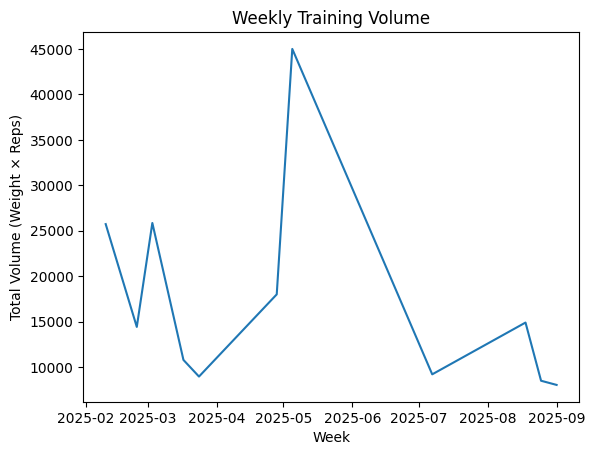

In [5]:
# Compute a proper week-start (Monday) for each session
session['WeekStart'] = pd.to_datetime(session['DateOnly']).astype('datetime64[ns]') \
    .dt.to_period('W').dt.start_time.dt.date

# Weekly metrics
weekly_freq   = session.groupby('WeekStart')['DateOnly'].nunique()
weekly_volume = session.groupby('WeekStart')['total_volume'].sum(min_count=1)

print("Weekly frequency (last 8):")
display(weekly_freq.tail(8))
print("Weekly total volume (last 8):")
display(weekly_volume.tail(8))

# Plot
plt.figure()
weekly_volume.plot(title="Weekly Training Volume")
plt.xlabel("Week")
plt.ylabel("Total Volume (Weight × Reps)")
plt.show()



## 5) Top exercises by lifetime volume

,sets,total_reps,total_volume
Exercise Name,,,
Hip Thrust (Barbell),59,580,"61,490.000"
Triceps Pushdown (Cable - Straight Bar),43,430,"29,450.000"
Squat (Machine),24,242,"14,330.000"
Lat Pulldown (Cable),21,210,"13,100.000"
Cable Curl,22,208,"12,490.000"
Squat (Smith Machine),12,120,"10,400.000"
Seated Row (Cable),15,150,"9,300.000"
Face Pull (Cable),28,253,"8,405.000"
Squat (Barbell),9,90,"7,400.000"


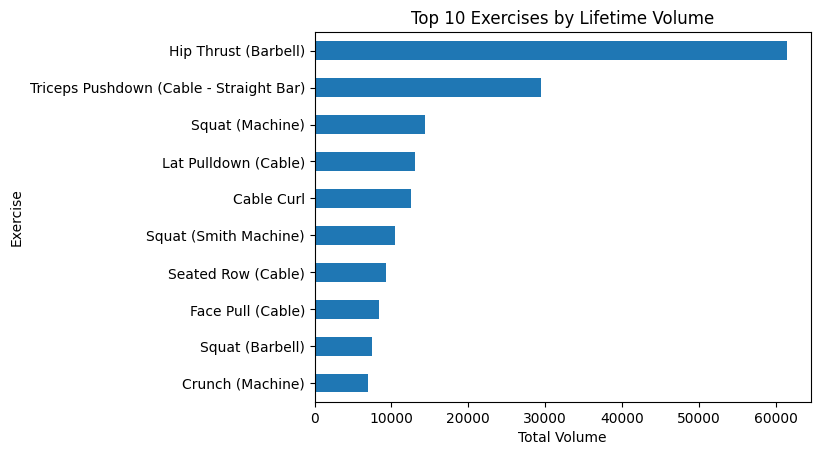

In [6]:

by_ex = df.groupby('Exercise Name').agg(
    sets=('Set Order','count'),
    total_reps=('Reps','sum'),
    total_volume=('Set_Volume','sum')
).sort_values('total_volume', ascending=False)

top10 = by_ex.head(10)
display(top10)

plt.figure()
top10['total_volume'].iloc[::-1].plot(kind='barh', title='Top 10 Exercises by Lifetime Volume')
plt.xlabel("Total Volume")
plt.ylabel("Exercise")
plt.show()


## 6) Personal Records (heaviest set per exercise)

In [7]:

prs = df.groupby('Exercise Name')['Weight'].max().sort_values(ascending=False).dropna()
prs.head(15)


Exercise Name
Hip Thrust (Barbell)                      156.000
Squat (Barbell)                            90.000
Squat (Smith Machine)                      90.000
Squat (Machine)                            70.000
Triceps Pushdown (Cable - Straight Bar)    70.000
Lat Pulldown (Cable)                       65.000
Seated Row (Cable)                         65.000
Cable Curl                                 65.000
Bicep Curl (Cable)                         55.000
Face Pull (Cable)                          45.000
Pec Deck (Machine)                         40.000
Crunch (Machine)                           35.000
Lying Leg Curl (Machine)                   35.000
Incline Bench Press (Dumbbell)             15.000
Seated Overhead Press (Dumbbell)           15.000
Name: Weight, dtype: float64

## 7) Save cleaned data

In [8]:
from pathlib import Path

out = Path("data/cleaned_strong.csv")     # <-- no ../
out.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out, index=False)
print("Saved:", out.resolve())


Saved: C:\Users\beatr\OneDrive\Desktop\Fitness-Data-Science-Project\data\cleaned_strong.csv
